<a href="https://colab.research.google.com/github/TuckerCullen/COVID-gene-expression/blob/main/CovidGeneExpressionML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examining COVID-19 Gene Expression using Machine Learning


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import random 

from scipy.stats import gmean

import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import VarianceThreshold


# Google Colab stuff
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Global Variables


Define path to dataset!!

In [ ]:
PATH_TO_DATASET = "/content/drive/My Drive/raw_counts_w_n1ct.txt"

# Helper Functions 

* `get_deseq_norm()` is one option for normalization of the raw gene counts
* `get_colors()` used to color points for plotting based on severity level  

In [ ]:
# input numpy array of raw counts 
# Row : Genes
# Column : Patient
def get_deseq_norm(raw_counts):
  raw_counts = raw_counts.astype(float)
  # Step 1: Take log of all values
  logs = np.log(raw_counts)
  # Step 2: Take average of rows
  Means = np.mean(logs, axis = 1).reshape(-1,1)
  # Step 3: Remove genes where there were 0 counts
  intermed = np.append(logs, Means, axis = 1)
  intermed = intermed[intermed[:,-1] != np.NINF] # select rows where first column is greater than 3
  logs_int = intermed[:,0:(intermed.shape[1])-1]
  Means = intermed[:, (intermed.shape[1])-1:(intermed.shape[1])]
  # Step 4: Subtract average log val from original log(counts)
  subLog = logs_int - Means
  # Step 5: Calculate median of ratios
  size_factor = np.median(subLog, axis = 0)
  # Step 6: Calculate Scaling Factor
  scaling_factor = np.exp(size_factor)
  normalized_counts = raw_counts/scaling_factor

  return normalized_counts

# Code for getting a color vector for plotting

def get_colors(n1cts, preds):
  severity = []
  for i in range(len(n1cts)):
    n1ct = n1cts[i]
    pred = preds[i]
    if (30.54 >= n1ct >= 24.00) and (pred >= 24.00):
      severity.append("Yellow")
    elif (23.99 >= n1ct >= 19.08) and (23.99 >= pred >= 19.08):
      severity.append("Orange")
    elif (19.07 >= n1ct >= 12.32) and (19.07 >= pred >= 12.32):
      severity.append("Red")
    elif n1ct < 12 and pred < 12:
      severity.append("Green")
    else:
      severity.append("Black")
  return severity

# Import Dataset + Preprocessing

Key Variables: 

* `counts` - a matrix where each row is a patient and each column in a gene count 
* `labels` - a list of strings denoting the severity of the case
* `n1_ct` - a list of n1_cts such that you can determine the label
* `genes` - genes is a list of genes in alphabetical order - this is the same order that they appear as columns for counts
* `counts_norm` - normalized counts 

These same varibles with `pos` in front of them denotes that they only contain information about pos and neg classifcations (not low, med, high). 

The Ct value cutoffs for the severity classification are taken from the Lieberman et al. paper (where this dataset was originally generated). 

In [ ]:
# Edit global variable PATH_TO_DATASET to define location of n1_cnts file
# rows are genes and columns are patients/samples
dataframe = pd.read_csv(PATH_TO_DATASET, sep=" ", header=0)

DESeq = False

########################### Seperating into FOUR Categories (Neg, Low, Medium, High) ##############################

# This just uses the n1ct values to assign a severity class and appends it as a row
n1cts = dataframe.iloc[-1].values.tolist()
severity = []
for n1ct in n1cts:
  if 30.54 >= n1ct >= 24.00:
    severity.append("Low")
  elif 23.99 >= n1ct >= 19.08:
    severity.append("Medium")
  elif 19.07 >= n1ct >= 12.32:
    severity.append("High")
  elif n1ct == -1:
    severity.append("Unk")
  else:
    severity.append("Neg")
dataframe.loc["Severity"] = severity

# transpose so samples are rows and genes are columns
df = dataframe.transpose()

# then we drop all of the rows with "unknown" n1 counts (only 17 of them)
df = df[df.Severity != "Unk"]
df = shuffle(df, random_state=40)

counts, label, n1_ct = [], [], [] 
data = list(df.values)
for line in data:
  counts.append(line[0:len(line) - 2])
  label.append(line[len(line)-1])
  n1_ct.append(line[len(line)-2])

# counts is a matrix where each row is a patient and each column in a gene count (counts is shuffled)
# label is a list of strings denoting the severity of the case
# n1_ct is a list of n1_cts such that you can determine the label
# genes is a list of genes in alphabetical order - this is the same order that they appear as columns for counts
counts = np.array(counts)
label = np.array(label)
n1_ct = np.array(n1_ct)
genes = np.array(list(df.columns)[0:len(list(df.columns))-2])

# Normalize All Counts the way DESeq2 does it
counts_norm = get_deseq_norm(counts.T).T

########################### Seperating into TWO Categories (just pos and neg) ##############################

pos_neg = []
for i in label:
  if i == 'Neg':
    pos_neg.append("Negative")
  else:
    pos_neg.append("Positive")

# isolate the positive patients 
pos_only = df[df.Severity != "Neg"]

pos_counts, pos_label, pos_n1_ct = [], [], [] 
data = list(pos_only.values)

for line in data:
  pos_counts.append(line[0:len(line) - 2])
  pos_label.append(line[len(line)-1])
  pos_n1_ct.append(line[len(line)-2])

pos_counts = np.array(pos_counts)
pos_label = np.array(pos_label)
pos_n1_ct = np.array(pos_n1_ct)

# Normalize the counts the way DESeq2 does it
pos_counts_norm = get_deseq_norm(pos_counts.T).T


# We tried the DESeq2 normalization but it did not prove to be better than log normalization
#-----------------------------------
if not DESeq:
  pos_counts_norm = pos_counts
  counts_norm = counts

df
#"RuntimeWarning: divide by zero encountered in log" is expected and accounted for as a result of DESeq normalization function

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


A1BG A1CF  A2M A2ML1 A2MP1  ... ZYX ZYXP1 ZZEF1  n1_ct Severity
POS_080    1    5  361     6     3  ...  40     0   106  25.69      Low
POS_390    3    0   16     0     0  ...   0     0    23  20.22   Medium
POS_367    7    0    5     5     0  ...  10     0   134   27.3      Low
POS_027    0    0    0     0     0  ...   4     0     7  17.31     High
POS_050   21    6   81     1     0  ...  14     0    82  25.22      Low
...      ...  ...  ...   ...   ...  ...  ..   ...   ...    ...      ...
NEG_031    6    0    3     0     0  ...   0     0    18      0      Neg
POS_171    2    0   53     0     1  ...   8     0    31  20.73   Medium
POS_008    1    0    0    32     0  ...  10     0     0  25.91      Low
POS_225    0    0  221    77     0  ...  56     0    81  27.24      Low
POS_335   13    0   84     0     3  ...  16     0    11  18.68     High

[467 rows x 35786 columns]

The positive only values : <i>pos_counts_norm</i>
* <i>pos_label</i> has the string labels, <i>pos_n1_c1</i> has the n1 counts
All patients : <i>counts_norm</i>
* <i>label</i> has the string labels, <i>n1_c1</i> has the n1 counts, <i>pos_neg</i> is binary label (either positive or negative)


# Principle Component Analysis (PCA)

PCA is used to reduce the dimensions of this extremely high dimensional genetic datset (35000+ genes compared to 484 samples). 

In this case, first 100 principle components account for 77% percent of the variance in the dataset. These first 100 PCs can be used to improve SVM Classifcation and Logisitic Regression, compared to using the entire dataset.

The loadings of the PCs tell us how much each gene contributes to the variance of the PC in question. The genes with the largest magnitude  loading contribute the most to the variance. Looking at what genes contribute the most to the first few PCs helps us determine what genes might be most important. 


## PCA - All Patients

For visualization purposes, we created two different dataframes, one with all patients (labeled as either covid positive or covid negative), and another with only the postive patients (labeled with low, medium, high severity sub-levels). We conducted PCA on these two dataframes seperately 


---------------------------------------------------------------
Total Variance Covered by PCA: 0.7751261118520131
---------------------------------------------------------------


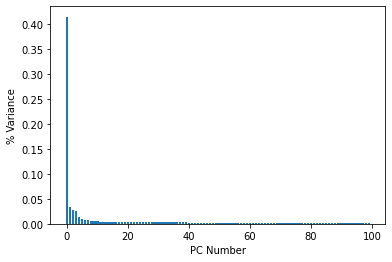

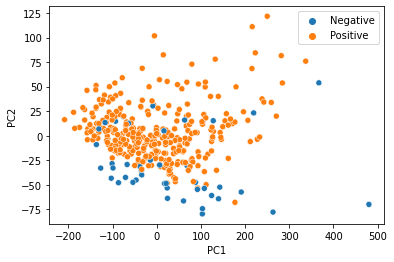

20 Most Signifigant Loadings for the FIRST PC -----------------------
Gene
DNAH1      0.014333
SMG1P3     0.013857
DNAH5      0.013808
UBE2H      0.013660
DNAH11     0.013538
ZFP36      0.013489
CDHR3      0.013448
DNAH10     0.013418
DLEC1      0.013411
CFAP157    0.013308
PLXNB2     0.013307
JMJD1C     0.013293
DNAH2      0.013243
NPIPB5     0.013211
DNAH12     0.013209
DNAH9      0.013179
IGSF10     0.013062
BIRC6      0.013057
HYDIN      0.013032
SMG1P1     0.012982
Name: PC1, dtype: float64

20 Most Signifigant Loadings for the SECOND PC ----------------------
Gene
TREM1         0.036027
SLC2A3        0.035296
CR1           0.033963
CSF3R         0.033929
FFAR2         0.033283
NABP1         0.032829
BEST1         0.032352
CXCR2         0.032296
FCAR          0.032100
AQP9          0.031997
ITGAX         0.031334
MEFV          0.031310
IL1B          0.031036
FPR2          0.031003
AL669831.1    0.030900
CXCR1         0.030679
ADGRG3        0.030677
AC066616.2    0.030026
AC139495.

In [ ]:
#Preprocessing
X = np.log(counts_norm.astype(float)+1)
y = pos_neg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

#apply PCA
pca = PCA(n_components = 100) #100 n_components brings us to 77.03% variance accounted for
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#examine variances (PCA uses n_features=min(samples, features) so there are only 0.2*(#patients) variances)
explained_variance = pca.explained_variance_ratio_
plt.bar(list(range(len(explained_variance))), explained_variance)
plt.ylabel('% Variance')
plt.xlabel('PC Number')

print("---------------------------------------------------------------")
print("Total Variance Covered by PCA:", np.sum(explained_variance))
print("---------------------------------------------------------------")

plt.show()
sns.scatterplot(x = X_train[:,0], y = X_train[:, 1], hue = y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Get and print the loadings for the first prinicple component 
num_pc = pca.n_components_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings = pca.components_
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['Gene'] = genes
loadings_df = loadings_df.set_index('Gene')
loadings_df = loadings_df.T

print("20 Most Signifigant Loadings for the FIRST PC -----------------------")
print(loadings_df.loc["PC1"].sort_values(ascending=False, key=lambda loading: abs(loading)).head(20))

print()
print("20 Most Signifigant Loadings for the SECOND PC ----------------------")
print(loadings_df.loc["PC2"].sort_values(ascending=False, key=lambda loading: abs(loading)).head(20))

## PCA - Just the COVID Positive Patients


---------------------------------------------------------------
Total Variance Covered by PCA: 0.7837994690302853
---------------------------------------------------------------


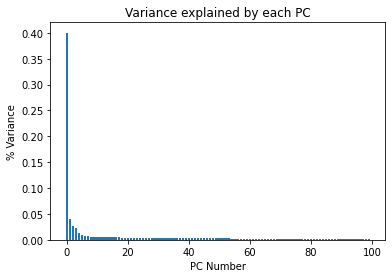

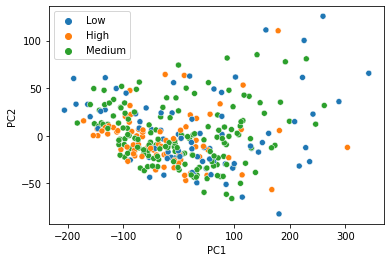

20 Most Signifigant Loadings for the FIRST PC -----------------------
Gene
JMJD1C        0.014434
TTN           0.014318
SMG1P3        0.014247
UBE2H         0.014015
AL669831.1    0.013979
BIRC6         0.013890
ZFP36         0.013841
SMG1P1        0.013773
NPIPB5        0.013765
DNAH1         0.013650
DLEC1         0.013527
VPS13D        0.013451
NPIPB3        0.013299
DNAH5         0.013248
ITGAX         0.013231
CDHR3         0.013210
PRKDC         0.013169
DNAH11        0.013083
DOCK2         0.013072
SNRNP200      0.013022
Name: PC1, dtype: float64

20 Most Signifigant Loadings for the SECOND PC ----------------------
Gene
TREM1         0.040842
CSF3R         0.038674
CXCR1         0.038393
HCAR3         0.038170
G0S2          0.037709
CXCR2         0.037417
FFAR2         0.036612
AC099489.1    0.035930
FPR2          0.035828
ADGRG3        0.035717
CXCL8         0.035385
PLAUR         0.035342
CR1           0.034414
BEST1         0.034132
AC066616.2    0.033870
FAM157A       0.03

In [ ]:
#Preprocessing
X = np.log(pos_counts_norm.astype(float)+1)
y = pos_label

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y, test_size=.2, random_state=0)

#apply PCA
pca = PCA(n_components = 100)
X_train_pos = pca.fit_transform(X_train_pos)
X_test_pos = pca.transform(X_test_pos)
#examine variances (PCA uses n_features=min(samples, features) so there are only 0.2*(#patients) variances)
explained_variance_pos = pca.explained_variance_ratio_

print("---------------------------------------------------------------")
print("Total Variance Covered by PCA:", np.sum(explained_variance_pos))
print("---------------------------------------------------------------")

plt.bar(list(range(len(explained_variance_pos))), explained_variance_pos)
plt.ylabel('% Variance')
plt.xlabel('PC Number')
plt.title("Variance explained by each PC")
plt.show()

sns.scatterplot(x = X_train_pos[:,0], y = X_train_pos[:, 1], hue = y_train_pos)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Get and print the loadings for the first prinicple component 
num_pc = pca.n_components_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings = pca.components_
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['Gene'] = genes
loadings_df = loadings_df.set_index('Gene')
loadings_df = loadings_df.T

print("20 Most Signifigant Loadings for the FIRST PC -----------------------")
print(loadings_df.loc["PC1"].sort_values(ascending=False, key=lambda loading: abs(loading)).head(20))

print()
print("20 Most Signifigant Loadings for the SECOND PC ----------------------")
print(loadings_df.loc["PC2"].sort_values(ascending=False, key=lambda loading: abs(loading)).head(20))


#t-Distributed Stochastic Neighbor Embedding (tSNE)

tSNE is a tool for creating better visualizations of high dimensional data. It uses local relationships between points to create a low dimensional mapping. 

We tested 56 different tSNE hyper-parameters to find the plot with the best clustering for visualization. 

## tSNE - All Patients

While not perfect, some of the tSNE plots that we generated illustrated clear clustering between covid positive and negative patients. 


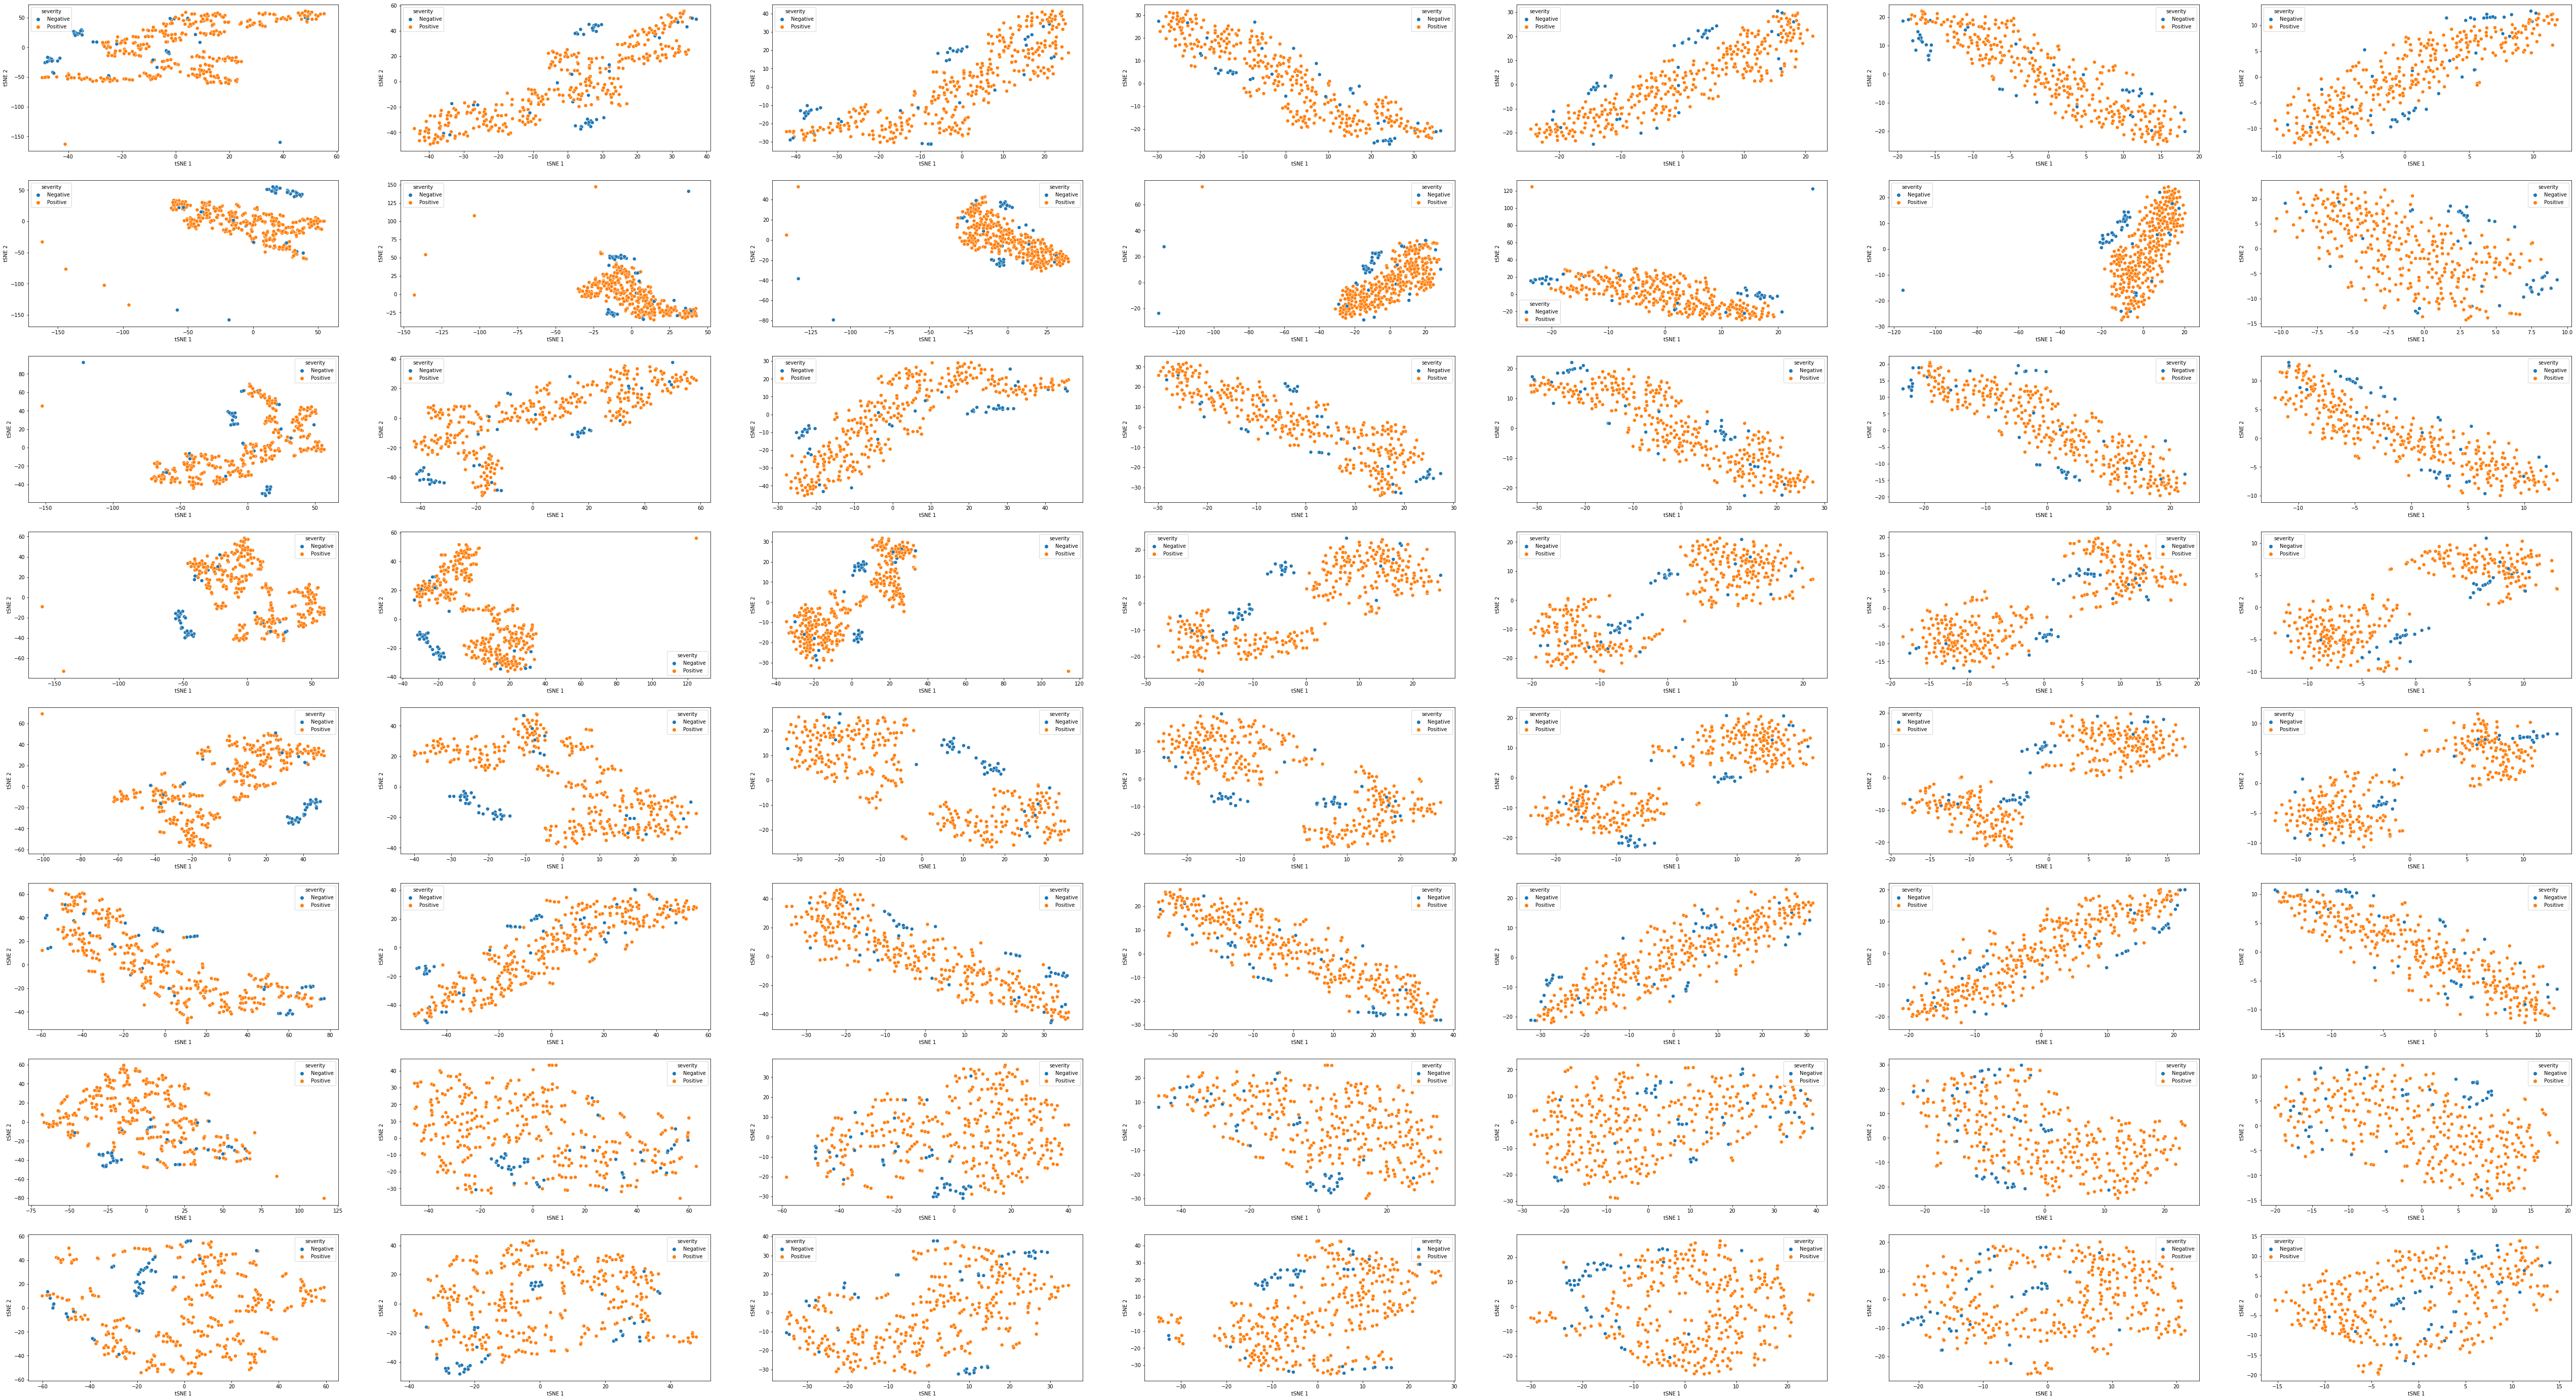

In [ ]:
to_tsne = X_train

metrics = ['euclidean', 'cityblock', 'sqeuclidean', 'cosine', 'correlation', 'chebyshev', 'canberra', 'braycurtis']
perps = [5,10,15,20,25,30,50]
severity = y_train
fig, axes = plt.subplots(8, 7, figsize=(90,50))
p = 0
m = 0
for measure in metrics:
  for perp in perps:
    tsne_results = TSNE(n_components=2, perplexity = perp, metric = measure).fit_transform(to_tsne)
    df_tsne = pd.DataFrame(tsne_results, columns=['tSNE 1', 'tSNE 2'])
    df_tsne['severity'] = severity
    sns.scatterplot(ax = axes[m, p], x = 'tSNE 1', y='tSNE 2', data = df_tsne, hue='severity', s=50)
    p += 1
  m+=1
  p = 0
plt.show()
#cosine and correlation for a perplexity of 5 show the best clustering

Below shows the two best plots out of all the hyper-parameters we tried. 

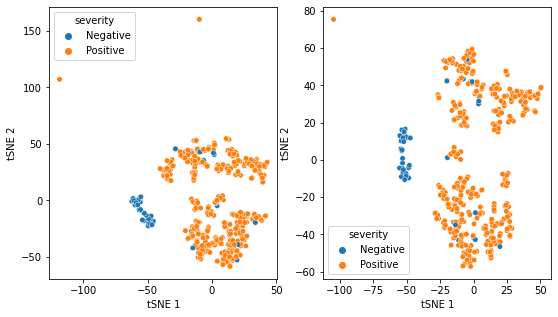

In [ ]:
# THE BEST tSNE FOR CLUSTERING Positive vs. Negative
severity = y_train
to_tsne = X_train

fig, axes = plt.subplots(1, 2, figsize=(9,5))
tsne_results = TSNE(n_components=2, perplexity = 5, metric = "cosine").fit_transform(to_tsne)
df_tsne1 = pd.DataFrame(tsne_results, columns=['tSNE 1', 'tSNE 2'])
df_tsne1['severity'] = severity
sns.scatterplot(ax = axes[0], x = 'tSNE 1', y='tSNE 2', data = df_tsne1, hue='severity', s=30)
tsne_results = TSNE(n_components=2, perplexity = 5, metric = "correlation").fit_transform(to_tsne)
df_tsne2 = pd.DataFrame(tsne_results, columns=['tSNE 1', 'tSNE 2'])
df_tsne2['severity'] = severity
sns.scatterplot(ax = axes[1], x = 'tSNE 1', y='tSNE 2', data = df_tsne2, hue='severity', s=30)
plt.show()

## tSNE - positive patients

When just looking at just the covid positive patients, none of the plots showed clear clustering between low, medium, and high viral loads. 

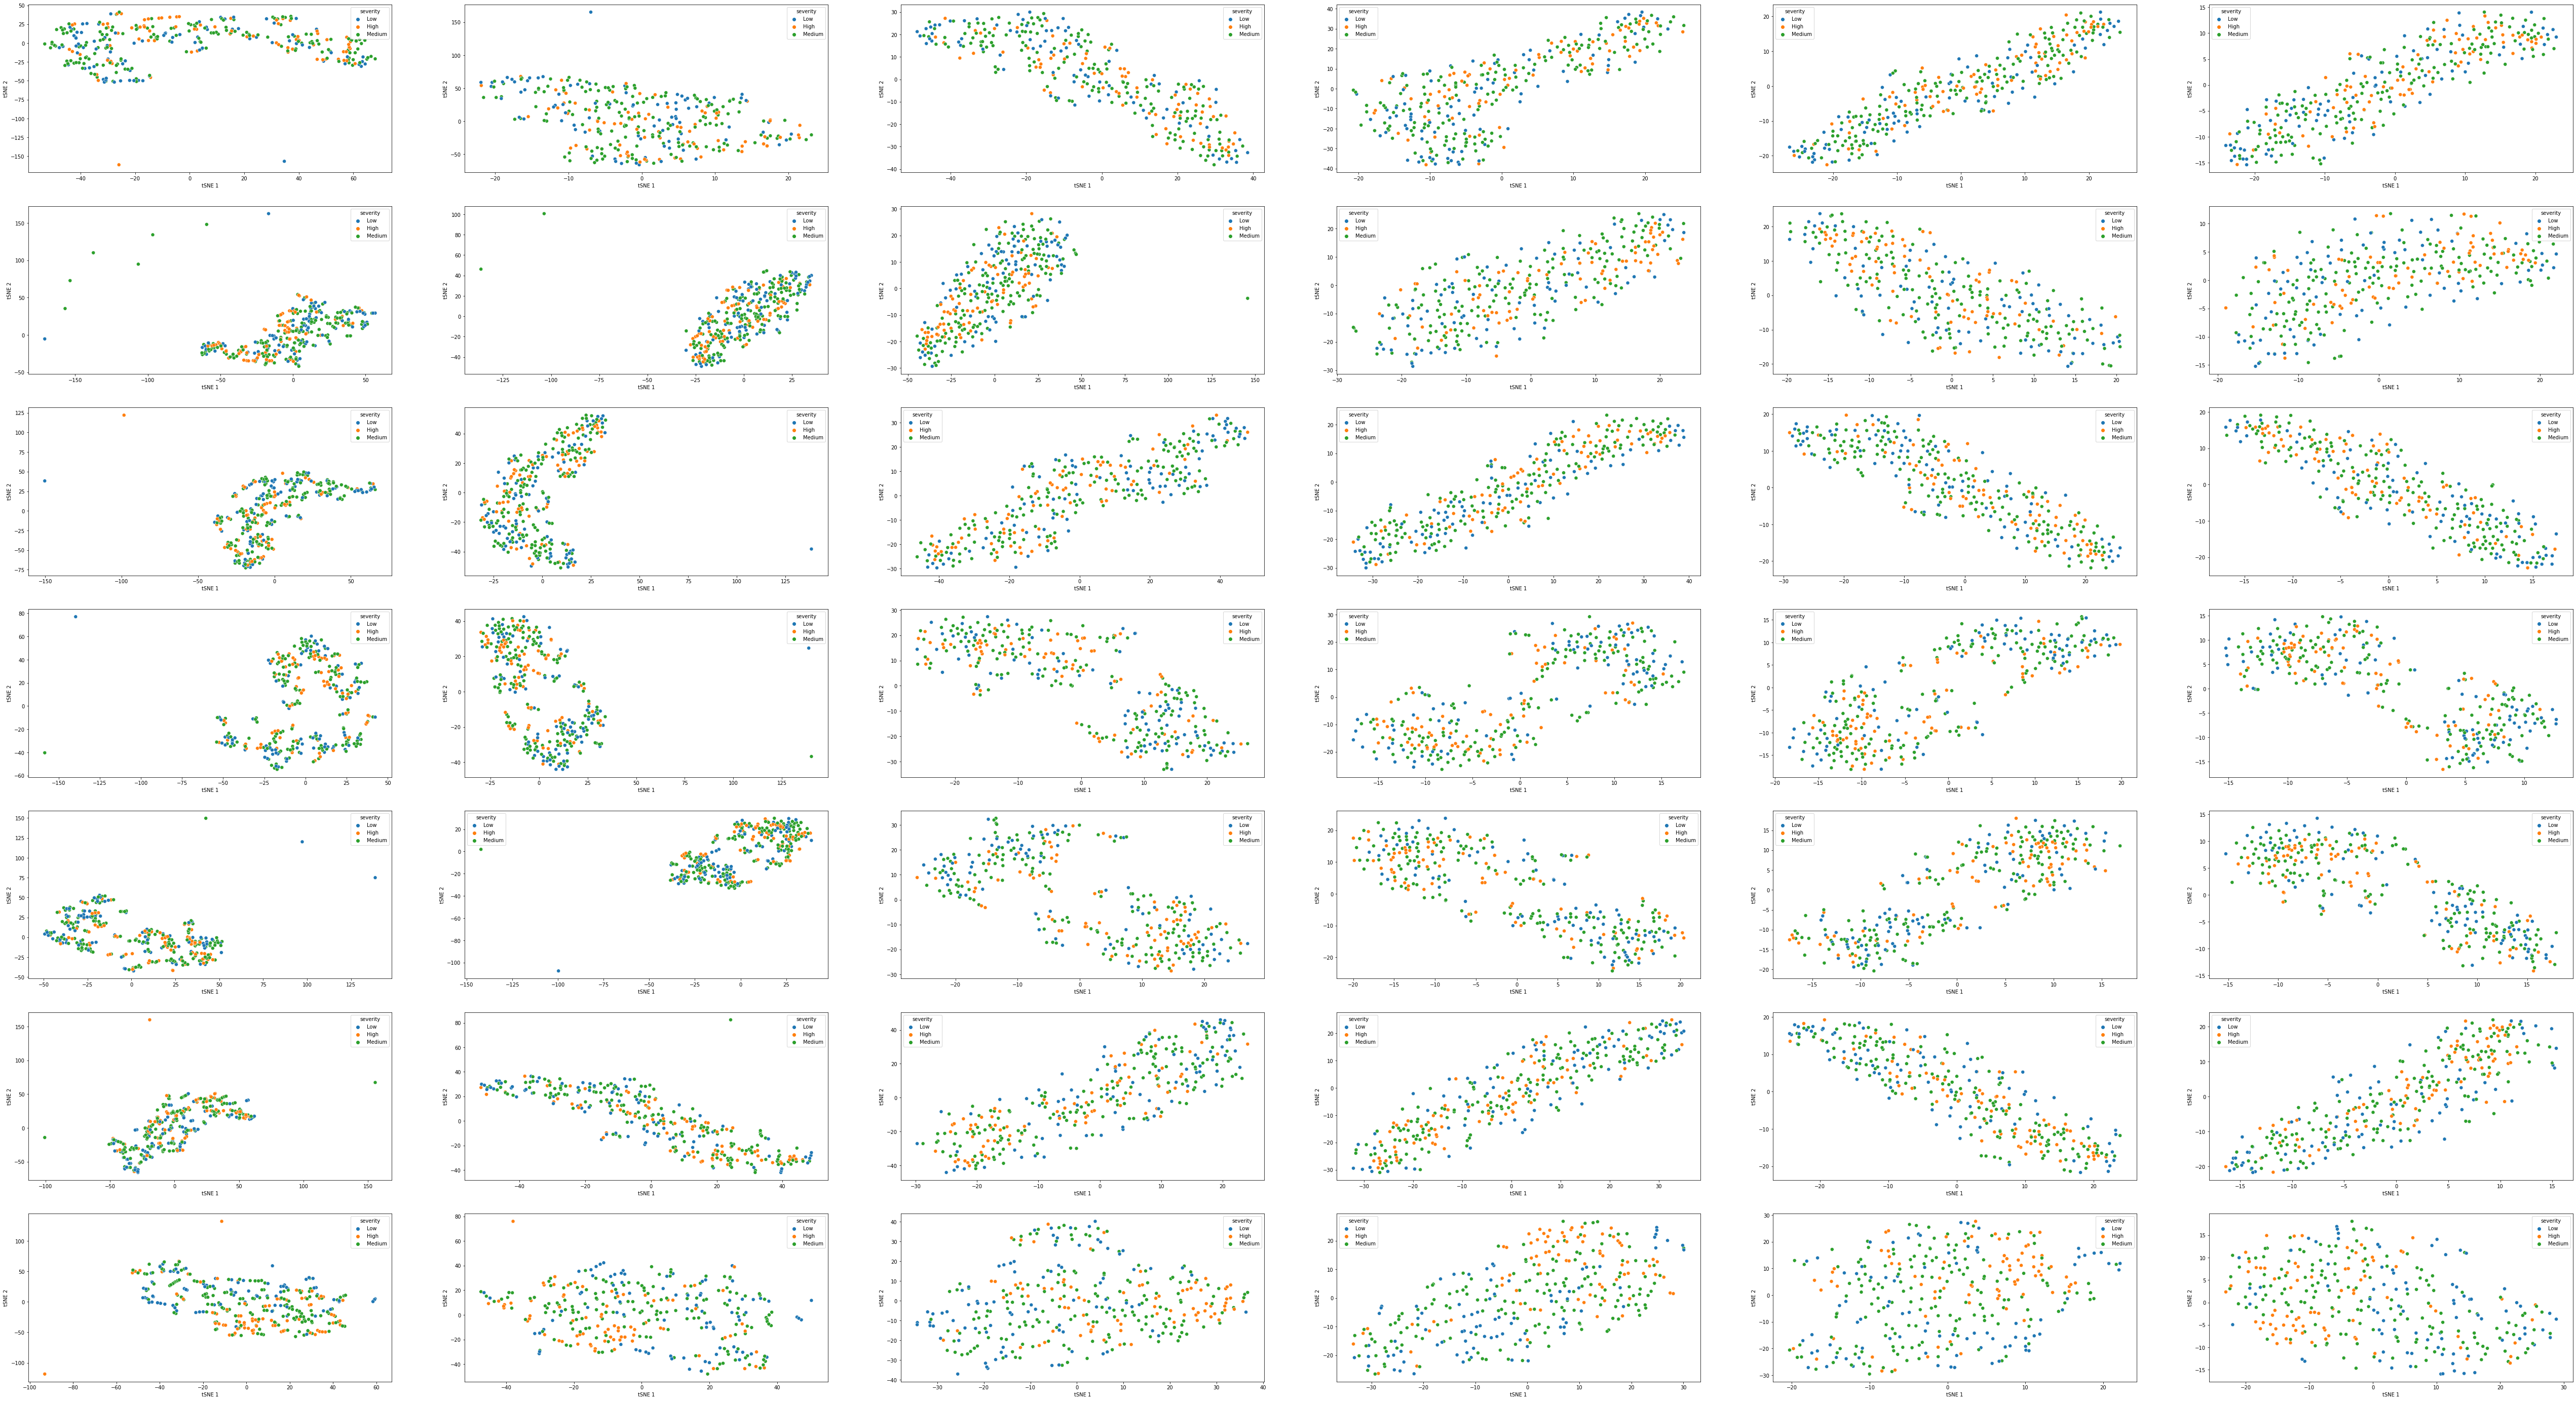

In [ ]:
# None of these cluster when using log(rawcount + 1)

to_tsne = X_train_pos

metrics = ['euclidean', 'cityblock', 'sqeuclidean', 'cosine', 'correlation', 'chebyshev', 'canberra']
severity = y_train_pos
perps = [5,10,15,20,25,30]
fig, axes = plt.subplots(7, 6, figsize=(90,50))
p = 0
m = 0
for measure in metrics:
  for perp in perps:
    tsne_results = TSNE(n_components=2, perplexity = perp, metric = measure).fit_transform(to_tsne)
    df_tsne = pd.DataFrame(tsne_results, columns=['tSNE 1', 'tSNE 2'])
    df_tsne['severity'] = severity
    sns.scatterplot(ax = axes[m, p], x = 'tSNE 1', y='tSNE 2', data = df_tsne, hue='severity',s=50)
    p += 1
  m+=1
  p = 0
plt.show()

#No clear clustering was seen

# Uniform Manifold Approximation and Projection (UMAP)

UMAP is a novel derivative of tSNE that essentially serves the same purpose (visualization of high dimensional data). We tested it in addition to tSNE to see if it provided better visualizations. 


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


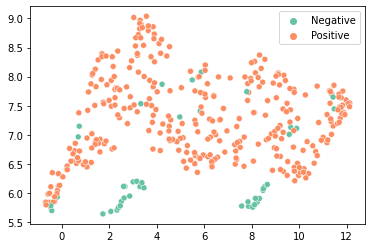

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


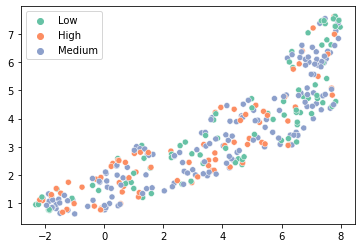

In [ ]:
# Here the pos_neg clustering is so-so and the severity still doesn't cluster

reducer = umap.UMAP()

count_embedded = reducer.fit_transform(X_train)
sns.scatterplot(count_embedded[:,0], count_embedded[:,1], hue=y_train, legend='full', palette=sns.color_palette("Set2", 2))

plt.show()

count_embedded = reducer.fit_transform(X_train_pos)
sns.scatterplot(count_embedded[:,0], count_embedded[:,1], hue=y_train_pos, legend='full', palette=sns.color_palette("Set2", 3))

# LASSO Regression 

LASSO regression serves the dual purpose of modelling the data and conducting feature selection. LASSO uses the L1 norm as a regularizer. Regression coefficients of unimportant features are minimized to zero when using LASSO, essentially eliminating them from the model. This behavior is what makes LASSO perferable to ridge regression or regular linear regression for our purposes, as LASSO helps us identify the most important genes. 

Before running LASSO, we also used the varience threshold feature selection method to eliminate some of the unimportant genes before regression. This improved the performance of the LASSO model. 

After LASSO, the most important genes (the features in our dataset) are assigned the largest beta coefficients. We isolate the top 20 such genes below. Some of these genes, such as PCSK5 (the gene with the largest coefficient), have been linked to COVID in other studies. Though most of the genes identified are not supported by previous literature. 

We also extracted the beta coefficients for the genes that were identified through differential expression in the Lieberman et al. paper (where we got the dataset). To our suprise, LASSO did not select for any of these genes. 


-------------------------------------------------
Lasso Score: 0.6231218563609107
-------------------------------------------------



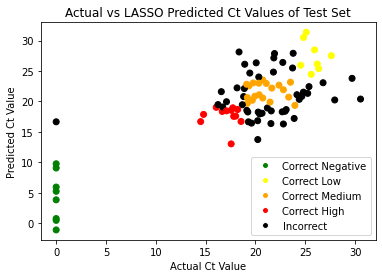


Top 20 genes with the largest magnitude beta values (regression coeficients): -------------------
('PCSK5', 0.7371915516046796)
('CBLC', -0.7140632934833219)
('CCNB1', 0.5784708914274146)
('ZNF600', -0.5412216342335994)
('LRRC37A3', 0.5256600185965765)
('RPL7P19', 0.4384487473132477)
('KLK13', 0.425506383109851)
('SNX10', -0.4171291095885962)
('LILRB4', 0.40048234716413994)
('HDHD3', -0.39451263059780994)
('MYDGF', -0.39338618635001793)
('FBXL20', 0.3804584803647836)
('RAD51', 0.37769429641028196)
('MICA', 0.3776647339150127)
('PTTG1IP', -0.3740260098744782)
('CCN1', -0.3711592973512957)
('CLSTN1', -0.3505275413127071)
('H2AJ', -0.34060929004807694)
('DDX60', 0.3317052190325741)
('IFI44L', 0.3282933580617394)

Beta Values of Genes Identified in Lieberman et al. Paper ----------------------------------------
('ACE2', 0.0)
('CCL2', -0.0)
('CD22', 0.0)
('CXCL8', 0.0)
('CXCL9', 0.0)
('IGHA1', -0.0)
('MX1', 0.0)
('OASL', -0.0)
('RPL4', -0.0)
('RPS6', 0.0)
('S100A9', -0.0)
('TMPRSS2', -0.0)

In [ ]:
posOnly = False

toLasso = pos_counts_norm
yLasso = pos_n1_ct

if not posOnly:
  toLasso = counts_norm
  yLasso = n1_ct

X = np.log(toLasso.astype(float)+1)
y = yLasso

# Set to do some premptive feature selection 
useVarThresh = True 
if (useVarThresh):
  sel = VarianceThreshold(threshold=.5)
  sel.fit(X)
  selected_genes = df[df.columns[sel.get_support(indices=True)]]
  X = sel.transform(X)
else:
  selected_genes = genes

X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X, y, test_size=.2, random_state=0)

lasso = linear_model.Lasso(alpha=0.01, max_iter=20000, tol=0.0001, random_state=0,selection='random')

lasso.fit(X_train_lasso, y_train_lasso)

lasso_prediction = lasso.predict(X_test_lasso)

lasso_score = lasso.score(X_test_lasso, y_test_lasso)

print()
print("-------------------------------------------------")
print("Lasso Score:", lasso_score)
print("-------------------------------------------------")
print()

legend_elements = [Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='green'),
                   Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='yellow'),
                   Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='orange'),
                   Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='red'),
                   Line2D([0], [0], marker='o', color='w',
                          markerfacecolor='black')]
fig, ax = plt.subplots()
ax.scatter(x=y_test_lasso, y=lasso_prediction, c=get_colors(y_test_lasso,lasso_prediction))
ax.legend(handles = legend_elements, labels=["Correct Negative","Correct Low","Correct Medium","Correct High","Incorrect"], loc='lower right')
plt.xlabel("Actual Ct Value")
plt.ylabel("Predicted Ct Value")
plt.title("Actual vs LASSO Predicted Ct Values of Test Set")
plt.show()

# Match the regression coeficients to the corresponding genes and sort by magnitude 
genes_coef = tuple(zip(selected_genes, lasso.coef_))
sorted_coefs = sorted(genes_coef, reverse=True, key=lambda coef: abs(coef[1])) 

# Top 20 genes 
print()
print("Top 20 genes with the largest magnitude beta values (regression coeficients): -------------------")
for gene in sorted_coefs[:20]:
  print(gene)


# Genes from Lieberman Paper 
print()
print("Beta Values of Genes Identified in Lieberman et al. Paper ----------------------------------------")
for tup in sorted_coefs:
  if tup[0] in ["ACE2", "TMPRSS2", "CXCL9", "OASL", "MX1", "CD274/PD-L1", "USP18", "CCL2", "RPL4", "RPS6", "IGHA1", "CD22", "CXCL8", "S100A9"]:
    print(tup)

# Elastic Net Regularization

We attempted using Elastic Net regularization (a combination of L1 and L2 regularization) to see if it performed better then LASSO. Unfortunately, we could not manage to get it to converge and produce meaningful output. 

The code below is set to not run since the model will fail to converge and run forever. 

In [ ]:
#runEN is false because it's not converging
runEN = False

if runEN:
  posOnly = False

  toLasso = pos_counts_norm
  yLasso = pos_n1_ct

  if not posOnly:
    toLasso = counts_norm
    yLasso = n1_ct

  X = toLasso
  y = yLasso
  X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X, y, test_size=.2, random_state=0)


  regr = ElasticNet(alpha=1, max_iter = 50000, l1_ratio = 0.9, )

  regr.fit(X_train_lasso, y_train_lasso)

  regr_prediction = regr.predict(X_test_lasso)

  regr_score = regr.score(X_test_lasso, y_test_lasso)

  print("EN Lasso Score:", regr_score)

  legend_elements = [Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='green'),
                    Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='yellow'),
                    Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='orange'),
                    Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='red'),
                    Line2D([0], [0], marker='o', color='w',
                            markerfacecolor='black')]
  fig, ax = plt.subplots()
  ax.scatter(x=y_test_lasso, y=regr_prediction, c=get_colors(y_test_lasso,regr_prediction))
  ax.legend(handles = legend_elements, labels=["Correct Negative","Correct Low","Correct Medium","Correct High","Incorrect"], loc='lower right')
  plt.show()

  # Match the regression coeficients to the corresponding genes and sort by magnitude 
  genes_coef = tuple(zip(genes, regr.coef_))
  sorted_coefs = sorted(genes_coef, reverse=True, key=lambda coef: abs(coef[1])) 

  # Top 20 genes 
  print()
  print("Top ten genes with the largest magnitude beta values (regression coeficients): -------------------")
  for gene in sorted_coefs[:20]:
    print(gene)

  # Genes from Lieberman Paper 
  print()
  print("Beta Values of Genes Identified in Lieberman et al. Paper ----------------------------------------")
  for tup in sorted_coefs:
    if tup[0] in ["ACE2", "TMPRSS2", "CXCL9", "OASL", "MX1", "CD274/PD-L1", "USP18", "CCL2", "RPL4", "RPS6", "IGHA1", "CD22", "CXCL8", "S100A9"]:
      print(tup)

# Linear Regression 

We also tested basic linear regression to see how it performed compared to LASSO. 

Like with our LASSO implementation, we initally employ the variance threshold feature selection technique to remove unimportant genes. 

The R-squared value turned out to be slighter better than with LASSO regression (indicating a better fit). However linear regression does not provide any feature selection capabilities like LASSO, making it less useful for our purposes. 

In [ ]:
#Preprocessing
posOnly = False

toLinReg = pos_counts_norm
yLinReg = pos_n1_ct

if not posOnly:
  toLinReg = counts_norm
  yLinReg = n1_ct

X = np.log(toLinReg.astype(float)+1)
y = yLinReg

useVarThresh = True
#We tried Feature Selection with VarianceThreshold but it lowered the R^2 value
if (useVarThresh):
  sel = VarianceThreshold(threshold=.5)
  sel.fit(X)
  selected_genes = df[df.columns[sel.get_support(indices=True)]]
  X = sel.transform(X)

#
X_train_linreg, X_test_linreg, y_train_linreg, y_test_linreg = train_test_split(X, y, test_size=.2, random_state=0)

regr = linear_model.LinearRegression()
regr = regr.fit(X_train_linreg, y_train_linreg)
y_pred = regr.predict(X_test_linreg)
linRegAcc = regr.score(X_test_linreg, y_test_linreg)

print('accuracy:', linRegAcc)

genes_coef = tuple(zip(genes, regr.coef_))
sorted_coefs = sorted(genes_coef, reverse=True, key=lambda coef: abs(coef[1])) 

# Top 20 genes 
print()
print("Top ten genes with the largest magnitude beta values (regression coeficients): -------------------")
for gene in sorted_coefs[:10]:
  print(gene)

# Genes from Lieberman Paper 
print()
print("Beta Values of Genes Identified in Lieberman et al. Paper ----------------------------------------")
for tup in sorted_coefs:
  if tup[0] in ["ACE2", "TMPRSS2", "CXCL9", "OASL", "MX1", "CD274/PD-L1", "USP18", "CCL2", "RPL4", "RPS6", "IGHA1", "CD22", "CXCL8", "S100A9"]:
    print(tup)

accuracy: 0.6399366513795115

Top ten genes with the largest magnitude beta values (regression coeficients): -------------------
('C1QL3', 0.04479591326388928)
('APC2', 0.044003378535041465)
('AC093815.1', -0.03991561147230459)
('ANKRD20A2P', 0.03832610713749679)
('GALNT12', 0.036298580205587114)
('CPHL1P', 0.03494702049468478)
('AGBL1', 0.03485315264350518)
('AC073073.1', -0.034301552449336935)
('BLM', 0.03365883792765527)
('AL645924.2', 0.0336106725170009)

Beta Values of Genes Identified in Lieberman et al. Paper ----------------------------------------
('CXCL9', -0.012548848112638905)
('CD22', 0.0098261088152216)
('CXCL8', -0.00979268567662273)
('CCL2', -0.0059958237319318024)
('ACE2', -0.00042153379228176404)


# Support Vector Classifier (SVC)

In addition to regression, we applied classification methods to see how well the data can be seperated into four cateorigies ("Neg", "Low", "Medium", and "High" viral loads) based on the gene expression. 

The first classifcation method we attempted was the support vector classifier (SVC) method. We tested multiple hyperparameter combinations to eventually achieve a classifcation accuracy of around 60%. 

Before implementing the SVC, PCA was conducted to reduce the dimensionality of the data to the first 100 PCs. 

Best Score:  0.5851063829787234
Best Params:  {'kernel': 'linear', 'C': 0.001, 'degree': 1}



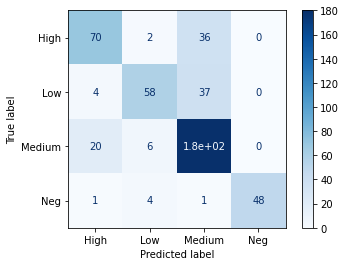

__________________________________________________________
All scores:  [0.574468085106383, 0.5851063829787234, 0.574468085106383]


In [ ]:
posOnly = False

toSVM = pos_counts_norm
ySVM = pos_label

if not posOnly:
  toSVM = counts_norm
  ySVM = label


X = np.log(toSVM.astype(float)+1)
y = ySVM
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X, y, test_size=.2, random_state=0)

#apply PCA
pca = PCA(n_components = 100)
X_train_SVM = pca.fit_transform(X_train_SVM)
X_test_SVM = pca.transform(X_test_SVM)

param_set = [
                #  {'kernel': 'rbf', 'C': 1, 'degree': 1},
                #  {'kernel': 'rbf', 'C': 3, 'degree': 1},
                #  {'kernel': 'linear', 'C': 1, 'degree': 1},
                #  {'kernel': 'linear', 'C': 0.1, 'degree': 1},
                 {'kernel': 'linear', 'C': 0.01, 'degree': 1},
                 {'kernel': 'linear', 'C': 0.001, 'degree': 1},
                 {'kernel': 'linear', 'C': 0.0001, 'degree': 1},
                #  {'kernel': 'linear', 'C': 10, 'degree': 1},
                #  {'kernel': 'poly', 'C': 2, 'degree': 20},
                #  {'kernel': 'poly', 'C': 1, 'degree': 1},
                #  {'kernel': 'poly', 'C': 1, 'degree': 2},
                #  {'kernel': 'poly', 'C': 1, 'degree': 3},
    ]

scores = []
best_score = 0
best_params = {}
for param in param_set:

  clf = SVC(C=param['C'], kernel=param['kernel'], degree=param['degree'], tol = 1e-5)

  clf.fit(X_train_SVM, y_train_SVM)

  clf_prediction = clf.predict(X_test_SVM)

  svm_score = clf.score(X_test_SVM, y_test_SVM)

  scores.append(svm_score)

  if svm_score > best_score:
    best_score = svm_score
    best_params = param
    best_prediction = clf_prediction
    best_SVC_model = clf


print("Best Score: ", best_score)
print("Best Params: ", best_params)
print()
plot_confusion_matrix(best_SVC_model, pca.transform(X), y, cmap=plt.cm.Blues)
plt.show()
print("__________________________________________________________")
print("All scores: ", scores)

# Logistic Regression

We also tried logistic regression classication method. After hyperparameter selection this achieved a similar accuracy to that of the SVC. 

Best Score:  0.5957446808510638
Best Params:  {'penalty': 'l2', 'C': 0.01, 'solver': 'lbfgs'}



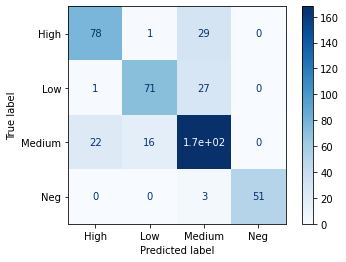

__________________________________________________________
All scores:  [0.5531914893617021, 0.5957446808510638, 0.5851063829787234]


In [ ]:
posOnly = False

toLOG = pos_counts_norm
yLOG = pos_label

if not posOnly:
  toLOG = counts_norm
  yLOG = label


X = np.log(toLOG.astype(float)+1)
y = yLOG
X_train_LOG, X_test_LOG, y_train_LOG, y_test_LOG = train_test_split(X, y, test_size=.2, random_state=0)

#apply PCA
pca = PCA(n_components = 100)
X_train_LOG = pca.fit_transform(X_train_LOG)
X_test_LOG = pca.transform(X_test_LOG)

param_set = [
            # {'penalty': 'l2', 'C': 1, 'solver' : 'lbfgs'},
             {'penalty': 'l2', 'C': 0.1, 'solver' : 'lbfgs'},
             {'penalty': 'l2', 'C': 0.01, 'solver' : 'lbfgs'},
             {'penalty': 'l2', 'C': 0.001, 'solver' : 'lbfgs'},
            # {'penalty': 'l2', 'C': 10, 'solver' : 'lbfgs'},
            # {'penalty': 'l1', 'C': 1, 'solver' : 'liblinear', },
            # {'penalty': 'l1', 'C': 1, 'solver' : 'saga'},
             #{'penalty': 'elasticnet', 'C': 1, 'solver' : 'saga', l1_ratio},
             #{'penalty': 'l2', 'C': 1, 'solver' : 'newton-cg'}, 
    ]

scores = []
best_score = 0
best_params = {}
for param in param_set:

  clf = linear_model.LogisticRegression(C=param['C'], penalty=param['penalty'], solver=param['solver'], max_iter=10000, tol = 1e-5)

  clf.fit(X_train_LOG, y_train_LOG)

  clf_prediction = clf.predict(X_test_LOG)

  LOG_score = clf.score(X_test_LOG, y_test_LOG)

  scores.append(LOG_score)

  if LOG_score > best_score:
    best_score = LOG_score
    best_params = param
    best_prediction = clf_prediction
    best_LOG_model = clf


print("Best Score: ", best_score)
print("Best Params: ", best_params)
print()
plot_confusion_matrix(best_LOG_model, pca.transform(X), y, cmap=plt.cm.Blues)
plt.show()
print("__________________________________________________________")
print("All scores: ", scores)